# EDA and Stakeholder Questions
* Conducting EDA to better understand the 2015-2015 King County housing data
* Addressing Stakeholder Questions


In [1]:
# Import the required libraries
import pandas as pd
import numpy as np

import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

# set up pandas to display floats in a more human friendly way
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# config and functions for charting 

sns.set_style(style='ticks')
sns.set_palette(palette='deep')

def plot_grouped_boxplot(plot_x, plot_y, plot_hue, plot_data, pal):
    sns.boxplot(x=plot_x, y=plot_y, hue=plot_hue, data=plot_data, palette=pal)
    sns.despine(offset=10, trim=True)
    plt.show()


def plot_grouped_violin(plot_x, plot_y, plot_hue, plot_hue_order, plot_data, pal):
    ax = sns.catplot(x=plot_x, y=plot_y, hue=plot_hue, kind='violin', hue_order=plot_hue_order, data=plot_data, palette=pal)
    plt.show()

In [3]:
# read in the processed data
df = pd.read_csv('../data/proc_kc_house_data.csv')
print(df.shape)
df.head(10)
len(df['id'].unique())

(21420, 28)


21420

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
0,7129300520,10/13/2014,"221,900.00",3,1.00,1180,5650,1.00,0,0,...,-122.26,1340,5650,10,13,2014,UNK,-160,0,N
1,6414100192,12/9/2014,"538,000.00",3,2.25,2570,7242,2.00,0,0,...,-122.32,1690,7639,12,9,2014,Y,880,-397,N
2,5631500400,2/25/2015,"180,000.00",2,1.00,770,10000,1.00,0,0,...,-122.23,2720,8062,2,25,2015,UNK,-1950,1938,N
3,2487200875,12/9/2014,"604,000.00",4,3.00,1960,5000,1.00,0,0,...,-122.39,1360,5000,12,9,2014,UNK,600,0,N
4,1954400510,2/18/2015,"510,000.00",3,2.00,1680,8080,1.00,0,0,...,-122.05,1800,7503,2,18,2015,UNK,-120,577,N


# Processed Data Column Descriptions

* id            - Unique identifier for house
* date          - Date house was sold
* price         - Sales price of home - __this is the prediction target__
* bedrooms      - Number of bedrooms
* bathrooms     - Number of bathrooms
* sqft_living   - Square footage of living area
* sqft_lot      - Square footage of  lot
* floors        - # floors (levels) in house
* waterfront    - Number from 0 to 1 reflecting if house is categorized as a waterfront property - Categorical
* view_rank     - Number from 0 to 4 reflecting quality of sceanic view - Categorical
* condition     - Number from 1 to 5 reflecting the overall condition of the property - Categorical
* grade         - Number from 1 to 13 refelecting the overall grade given to the property, based on King County grading system
* sqft_above    - Square footage of living area above ground/ (is this sqft_living - sqft_basement?) from basement
* sqft_basement - Square footage of the basement
* yr_built      - Year house was built
* yr_renovated  - Year house was renovated
* zipcode       - zip code
* lat           - Latitude coordinate
* long          - Longitude coordinate
* sqft_living15 - Average square footage of living area of the nearest 15 neighbors 
* sqft_lot15    - Average square footage of the  lots of the nearest 15 neighbors
* date_month    - ADDED month of sale date
* date_day      - ADDED day of sale date
* date_year     - ADDED year of sale date
* renovated_status      - ADDED Value Y/N/UNK refelecting the renovated status
* sqft_living15_diff    - ADDED difference between home living area and nearest neighbors average living area
* sqft_lot15_diff       - ADDED difference between home lot and nearest neighbors average lot 
* scenic_status   - ADDED Value Y/N reflecting if the home is waterfront OR has view ranked above 1 (middle value of view quality scale).
    * Thanks to fellow Data Science cohort member, Nick K., for the Data Column Descriptions

## Basic data investigation
* Look for outliers and drop when appropriate

In [5]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,sqft_living15_diff,sqft_lot15_diff
count,"21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00",...,"21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00","21,420.00"
mean,"4,580,939,869.16","541,861.43",3.37,2.12,"2,083.13","15,128.04",1.50,0.01,0.23,3.41,...,"98,077.87",47.56,-122.21,"1,988.38","12,775.72",6.56,15.69,"2,014.33",94.75,"2,352.32"
std,"2,876,761,172.45","367,556.94",0.93,0.77,918.81,"41,530.80",0.54,0.08,0.77,0.65,...,53.48,0.14,0.14,685.54,"27,345.62",3.12,8.64,0.47,601.30,"29,022.93"
min,"1,000,102.00","78,000.00",1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,...,"98,001.00",47.16,-122.52,399.00,651.00,1.00,1.00,"2,014.00","-2,310.00","-326,879.00"
25%,"2,123,537,386.75","324,950.00",3.00,1.75,"1,430.00","5,040.00",1.00,0.00,0.00,3.00,...,"98,033.00",47.47,-122.33,"1,490.00","5,100.00",4.00,8.00,"2,014.00",-220.00,-420.25
50%,"3,904,921,185.00","450,550.00",3.00,2.25,"1,920.00","7,614.00",1.50,0.00,0.00,3.00,...,"98,065.00",47.57,-122.23,"1,840.00","7,620.00",6.00,16.00,"2,014.00",0.00,0.00
75%,"7,308,900,186.25","645,000.00",4.00,2.50,"2,550.00","10,690.50",2.00,0.00,0.00,4.00,...,"98,117.00",47.68,-122.12,"2,370.00","10,086.25",9.00,23.00,"2,015.00",310.00,680.00
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,...,"98,199.00",47.78,-121.31,"6,210.00","871,200.00",12.00,31.00,"2,015.00","8,690.00","1,225,778.00"


<AxesSubplot:xlabel='price'>

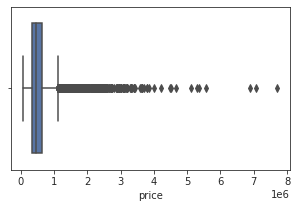

In [11]:
# Price max is really huge! Let's look at geting rid of these outliers
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x=df['price'])

In [12]:
# Get the records where price is an outlier.  Where price's Z score is > 3 (price is more than 3 STD away from mean).
z_price = np.abs(scs.zscore(df['price']))
price_outliers_df = df.iloc[np.where(z_price > 3)]
print(price_outliers_df.shape)
print(price_outliers_df.price.describe())  # all of the price outliers are to the left side of the distribution. Expensive homes.

(404, 28)
count         404.00
mean    2,280,049.50
std       769,462.12
min     1,650,000.00
25%     1,797,500.00
50%     2,000,000.00
75%     2,500,000.00
max     7,700,000.00
Name: price, dtype: float64


(21016, 28)
count      21,016.00
mean      508,447.46
std       259,118.06
min        78,000.00
25%       320,000.00
50%       449,500.00
75%       630,000.00
max     1,640,000.00
Name: price, dtype: float64


<AxesSubplot:xlabel='price'>

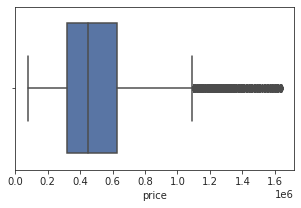

In [20]:
# Drop the SUPER EXPENSIVE homes from the dataset.
price_outliers_dropped_df = df.iloc[np.where(z_price < 3)]
print(price_outliers_dropped_df.shape)
print(price_outliers_dropped_df.price.describe())
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x=price_outliers_dropped_df['price'])

In [35]:
# Now take a look at the other attributes now that we've dropped the SUPER Expensive homes.
price_outliers_dropped_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,sqft_living15_diff,sqft_lot15_diff
count,"21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00",...,"21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00","21,016.00"
mean,"4,593,098,963.20","508,447.46",3.36,2.09,"2,035.15","14,863.68",1.49,0.00,0.21,3.41,...,"98,078.21",47.56,-122.21,"1,962.14","12,652.11",6.57,15.70,"2,014.32",73.02,"2,211.56"
std,"2,878,358,699.36","259,118.06",0.92,0.74,837.25,"40,539.84",0.54,0.06,0.71,0.65,...,53.37,0.14,0.14,655.49,"27,269.21",3.12,8.63,0.47,552.83,"28,248.06"
min,"1,000,102.00","78,000.00",1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,...,"98,001.00",47.16,-122.52,399.00,651.00,1.00,1.00,"2,014.00","-2,310.00","-326,879.00"
25%,"2,126,049,139.50","320,000.00",3.00,1.50,"1,420.00","5,001.75",1.00,0.00,0.00,3.00,...,"98,033.00",47.47,-122.33,"1,480.00","5,079.75",4.00,8.00,"2,014.00",-220.00,-419.00
50%,"3,905,030,260.00","449,500.00",3.00,2.25,"1,900.00","7,560.00",1.50,0.00,0.00,3.00,...,"98,065.00",47.57,-122.23,"1,830.00","7,573.00",6.00,16.00,"2,014.00",0.00,0.00
75%,"7,334,500,097.50","630,000.00",4.00,2.50,"2,510.00","10,496.25",2.00,0.00,0.00,4.00,...,"98,118.00",47.68,-122.12,"2,330.00","10,000.00",9.00,23.00,"2,015.00",300.00,661.00
max,"9,900,000,190.00","1,640,000.00",33.00,7.50,"7,480.00","1,651,359.00",3.50,1.00,4.00,5.00,...,"98,199.00",47.78,-121.31,"5,790.00","871,200.00",12.00,31.00,"2,015.00","5,250.00","1,225,778.00"


<AxesSubplot:xlabel='bedrooms'>

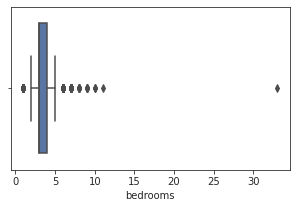

In [21]:
#Let's inspect bedrooms.
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x=price_outliers_dropped_df['bedrooms'])

In [22]:
# What is going on with the 33 bedroom house???
price_outliers_dropped_df.loc[price_outliers_dropped_df['bedrooms']==33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
15710,2402100895,6/25/2014,"640,000.00",33,1.75,1620,6000,1.00,0,0,...,-122.33,1330,4700,6,25,2014,UNK,290,1300,N


/home/user/anaconda3/envs/flatiron/lib/python3.6/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='bedrooms'>

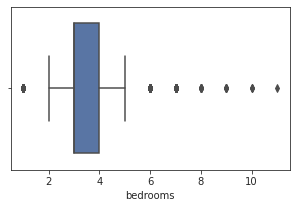

In [24]:
# Drop this record - looks like a data entry error. A home with 1 floor, 1620 sqft living area, and 1.75 bathrooms can't have 33 bedrooms.
error_index = price_outliers_dropped_df[price_outliers_dropped_df['bedrooms']==33].index
price_outliers_dropped_df.drop(error_index, inplace=True)
price_outliers_dropped_df.bedrooms.describe()
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x=price_outliers_dropped_df['bedrooms'])

<AxesSubplot:xlabel='bathrooms'>

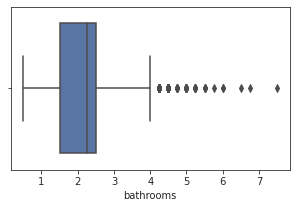

In [25]:
#Let's inspect bathrooms.  Seems in line with bedrooms. No action needed.
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x=price_outliers_dropped_df['bathrooms'])

count   21,015.00
mean         1.49
std          0.54
min          1.00
25%          1.00
50%          1.50
75%          2.00
max          3.50
Name: floors, dtype: float64


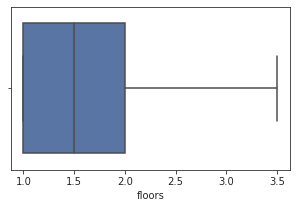

In [27]:
# Let's look at floors. Nothing too strange here. 3.5 is a bit odd for a number of floors. Let's look closer at those homes.
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x=price_outliers_dropped_df['floors'])  
print(price_outliers_dropped_df['floors'].describe())

In [28]:
# 3.5 is a little odd, but the other attributes seem legit. Leave these in the dataset.
price_outliers_dropped_df[price_outliers_dropped_df['floors']==3.5]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
9981,1972202010,8/1/2014,"435,000.00",3,3.00,1440,1350,3.50,0,2,...,-122.34,1440,1350,8,1,2014,N,0,0,Y
11480,3180100023,1/30/2015,"544,000.00",3,2.50,1760,1755,3.50,0,0,...,-122.28,1700,1721,1,30,2015,UNK,60,34,N
14740,8673400177,4/2/2015,"525,000.00",3,3.00,1730,1074,3.50,0,0,...,-122.39,1370,1185,4,2,2015,N,360,-111,N
15270,1702900664,4/16/2015,"479,000.00",2,2.50,1730,1037,3.50,0,0,...,-122.28,1280,1026,4,16,2015,N,450,11,N
20119,1972200426,9/18/2014,"525,000.00",2,2.75,1310,1268,3.50,0,0,...,-122.36,1350,1288,9,18,2014,N,-40,-20,N
20581,1972200428,6/25/2014,"563,500.00",3,2.50,1400,1312,3.50,0,0,...,-122.36,1350,1312,6,25,2014,N,50,0,N


<AxesSubplot:xlabel='sqft_living'>

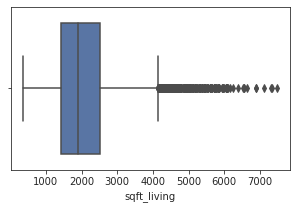

In [29]:
#Let's inspect sqft_living
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x=price_outliers_dropped_df['sqft_living'])
# There are quite a few outliers to sqft_living. With a left tail...outliers that have high sqft_living values.

### How to handle sqft_living left tail outliers?

Before we consider dropping the left tail outliers for sqft_living, let's reflect:
* We've already removed the expensive homes /price outliers
* Consider that this data is for the entire county which includes Urban and Rural areas
* The Urban areas include cities like Seattle and Redmond

This variety of Urban and Rural areas in King County most likely accounts for the variety in sqft_living even AFTER we've removed the most expensive homes.  Leaving these homes in the dataset for now. (__Spoiler Alert__: This might cause some issues with trying to predict home prices.

### Grade

Now let's check __grade__ as it is a metric used by the county to to access home value/quality in respect to builing code/ building materials used.

Recall the definition of _grade_ is  "a number from 1 to 13 reflecting the overall grade given to the property". Here are some insights from  the __Grade ratings definitions from [King County](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#building%20grade)__


* Grade below 6: does not meet building code
* Grade 6: lowest grade meeting building code
* Grade 7-8: average
* Grades 10-12: above average
* Grade 13: Mansion level
    * Shoutout/thank you to fellow cohort member, Kristen D., for sharing this resource.


In [30]:
print(price_outliers_dropped_df['grade'].describe())
print(np.sort(price_outliers_dropped_df['grade'].unique()))

count   21,015.00
mean         7.61
std          1.11
min          3.00
25%          7.00
50%          7.00
75%          8.00
max         12.00
Name: grade, dtype: float64
[ 3  4  5  6  7  8  9 10 11 12]


<AxesSubplot:>

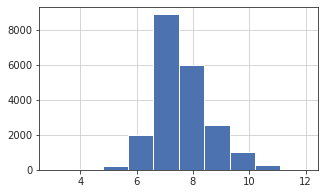

In [31]:
fig, ax = plt.subplots(figsize=(5,3))
price_outliers_dropped_df['grade'].hist()

### How to handle grade

Before we do anything, let's reflect:
* All of the values for grade are within range.
* The distribution of grade reflects the description with 7-8 being "Average" grade.

This data seems correct so do __not__ drop any values based on grade.


### Condition

Now let's check __condition__ as it is a metric used by the county to to access home value/quality in respect to builing code/ building materials used.


Recall the definition of _grade_ is  "a number from 1 to 5 reflecting the overall current condition of the property relative to age and grade.". Here are some insights from  the __Building Condition ratings definitions from [King County](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#b)__


* Condition 1: Poor
* Condition 2: Fair
* Condition 3: average
* Condition 4: Good
* Condition 5: Very Good
    * Shoutout/thank you to fellow cohort member, Kristen D., for sharing this resource.

In [32]:
print(price_outliers_dropped_df['condition'].describe())
print(np.sort(price_outliers_dropped_df['condition'].unique()))

count   21,015.00
mean         3.41
std          0.65
min          1.00
25%          3.00
50%          3.00
75%          4.00
max          5.00
Name: condition, dtype: float64
[1 2 3 4 5]


<AxesSubplot:>

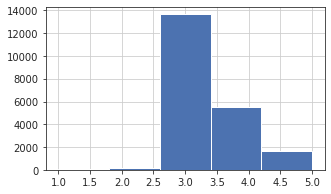

In [33]:
fig, ax = plt.subplots(figsize=(5,3))
price_outliers_dropped_df['condition'].hist(bins=5)

### How to handle condition

Before we do anything, let's reflect:
* All of the values for condition are in range. 
* The distribution of condition reflects the description with 3 being "Average" condition.

This data seems correct so do __not__ drop any values based on condition.

#### After further exploration and some outlier/error removal. Save the dataframe for use in price prediction analysis.

In [34]:
price_outliers_dropped_df.to_csv('../data/prepped_for_price_prediction.csv', index=False)

# Persona: Buyers looking for a scenic homes

Stakeholders is this scenario are home buyers who are specifically looking to buy a home in King County that has scenic attributes: homes that are listed as waterfront and/or have a higher than average view score (0,1,2,3,4 are the view categories. Considering anything 2 and above as a good view).   

Questions:
* Where are these homes typically located in King County? Geographically and Zipcode.
* How much more expensive are these homes from others?  Compare against homes in same zipcode.
* FUTURE WORK
        * How do scenic homes compare to neighboring homes
            * (sqft_living15 and sqft_lot15).
            * grade?
            * condition?


Data from the (King County Assesor Report)[https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx)]:
* "Location, views, zoning, topography, lot size and traffic are primary influences to land values."
* "Data on lot size, location, topography, access, utilities, views and waterfront were considered while developing the land model." 
* "A typical 5,000 square foot, non-view, SF 5000 zoned lot has a value of 505,000 to 775,000 based on neighborhood"
* "Neighborhood 50 is located on the west side of Capitol Hill along Interstate 5. Many of the parcels have view amenities, including Seattle Skyline, Lake Washington, and Small Lake River (Lake Union) views. The housing stock is comprised mostly of grade 8’s and 9’s, and approximately 7% are townhouses. The average time adjusted sales price in this neighborhood is 1,260,000."
    * Thank you/shout out to Gabby A. for finding and sharing the Report with the rest of the cohort!


In [35]:
# get ONLY the scenic homes 
scenic_df = price_outliers_dropped_df.loc[price_outliers_dropped_df['scenic_status'] == 'Y']
print(scenic_df.shape)
scenic_df.head(10)

(1567, 28)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
15,9297300055,1/24/2015,"650,000.00",4,3.00,2950,5000,2.00,0,3,...,-122.38,2140,4000,1,24,2015,UNK,810,1000,Y
49,822039084,3/11/2015,"1,350,000.00",3,2.50,2753,65005,1.00,1,2,...,-122.45,2680,72513,3,11,2015,UNK,73,-7508,Y
58,7922800400,8/27/2014,"951,000.00",5,3.25,3250,14342,2.00,0,4,...,-122.12,2960,11044,8,27,2014,UNK,290,3298,Y
60,1516000055,12/10/2014,"650,000.00",3,2.25,2150,21235,1.00,0,3,...,-122.34,2570,18900,12,10,2014,UNK,-420,2335,Y
98,7338200240,5/16/2014,"437,500.00",3,2.50,2320,36847,2.00,0,2,...,-121.71,2550,35065,5,16,2014,UNK,-230,1782,Y
112,6126500060,11/24/2014,"329,950.00",3,1.75,2080,5969,1.00,0,2,...,-122.30,2090,5500,11,24,2014,UNK,-10,469,Y
119,7278700070,1/2/2015,"660,000.00",3,2.50,2400,6474,1.00,0,2,...,-122.39,2340,10856,1,2,2015,UNK,60,-4382,Y
125,4058801670,7/17/2014,"445,000.00",3,2.25,2100,8201,1.00,0,2,...,-122.24,2660,8712,7,17,2014,UNK,-560,-511,Y
177,5437810320,11/17/2014,"269,950.00",3,1.50,1950,7560,1.00,0,2,...,-122.00,1950,8941,11,17,2014,UNK,0,-1381,Y
184,825059270,11/21/2014,"1,100,000.00",5,3.00,4090,12850,1.00,0,2,...,-122.19,2540,10270,11,21,2014,UNK,1550,2580,Y


Text(0.5, 1.0, 'Scenic Home Price by Lat/Long Coordinates')

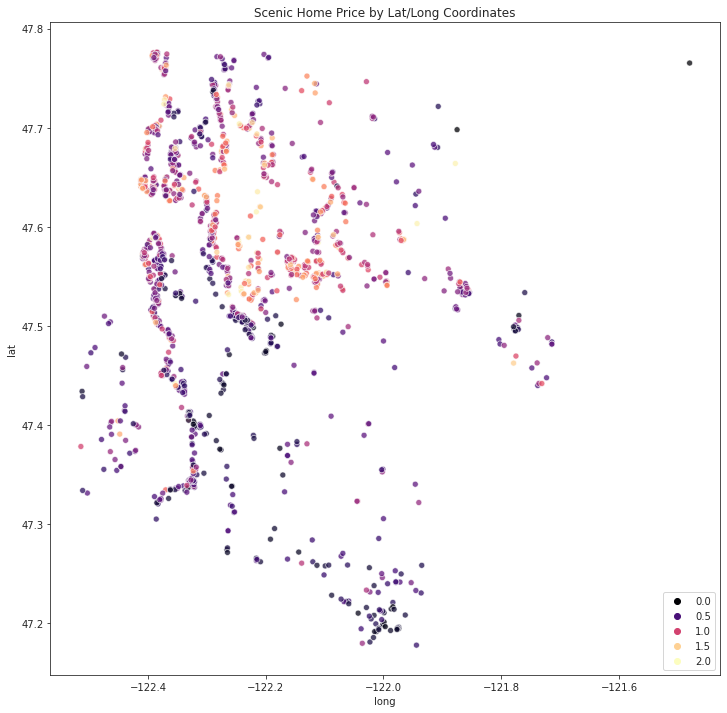

In [36]:
sns.set_style(style='ticks')
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='long', y='lat', hue=scenic_df.price.tolist(), palette='magma', data=scenic_df, alpha=0.75)
# add a title manually
ax.legend(title='price')
plt.legend(loc='lower right')
plt.title('Scenic Home Price by Lat/Long Coordinates')

Text(0.5, 1.0, 'Scenic Homes (Waterfront Status) by Lat/Long Coordinates')

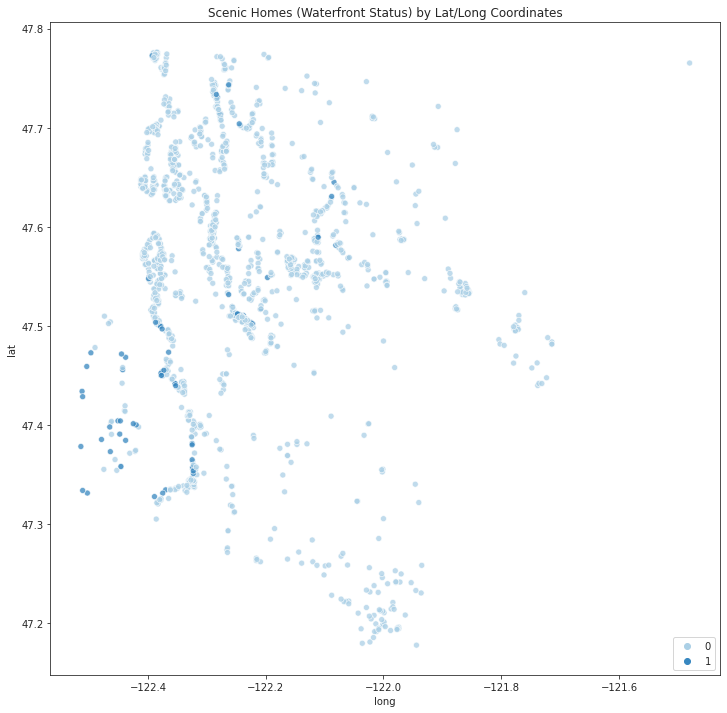

In [37]:
sns.set_style(style='ticks')
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='long', y='lat', hue=scenic_df.waterfront.tolist(), palette='Blues', data=scenic_df, alpha=0.75)
# add a title manually
ax.legend(title='waterfront')
plt.legend(loc='lower right')
plt.title('Scenic Homes (Waterfront Status) by Lat/Long Coordinates')

Text(0.5, 1.0, 'Scenic Homes (View status) by Lat/Long Coordinates')

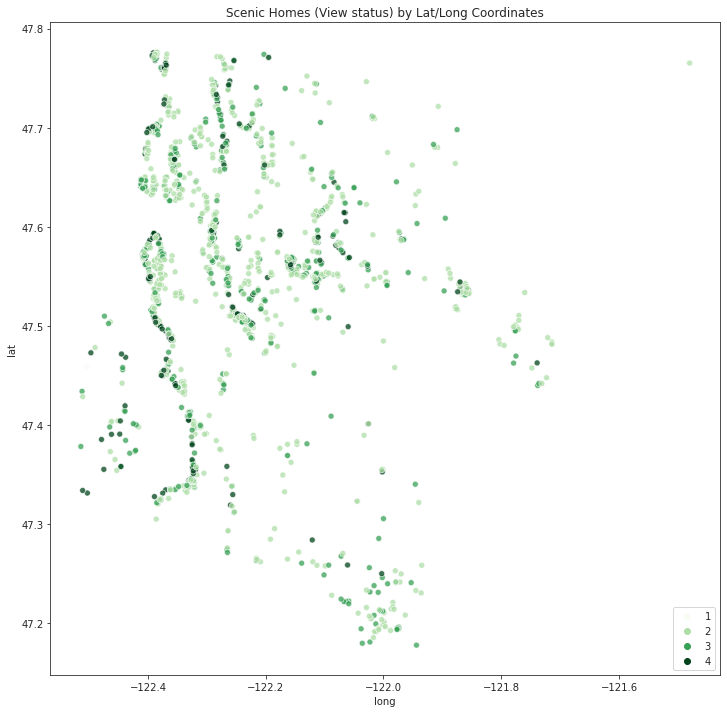

In [38]:
sns.set_style(style='ticks')
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='long', y='lat', hue=scenic_df.view_rank.tolist(), palette='Greens', data=scenic_df, alpha=0.75)
# add a title manually
ax.legend(title='view_rank')
plt.legend(loc='lower right')
plt.title('Scenic Homes (View status) by Lat/Long Coordinates')

In [39]:
# group the scenic homes by zip code. lat/long is cool to get geo idea but buyers use zipcode to search.
scenic_by_zip = scenic_df.groupby('zipcode')['id'].count()
scenic_by_zip.sort_values(ascending=False, inplace=True)
print(len(scenic_by_zip))
print(scenic_by_zip.values)
print(scenic_by_zip.index)
# there are 69 out of 70 zip codes and some have very few scenic homes. 

69
[87 61 61 59 56 56 53 52 50 48 47 43 41 41 39 38 36 36 35 34 34 32 30 30
 29 24 24 24 21 21 20 20 20 19 18 18 14 13 12 12 12 11 10 10 10  8  8  8
  7  7  7  7  6  6  5  4  4  4  4  4  4  3  2  2  2  1  1  1  1]
Int64Index([98006, 98177, 98116, 98022, 98199, 98126, 98166, 98198, 98178,
            98136, 98144, 98040, 98070, 98118, 98008, 98115, 98117, 98065,
            98146, 98103, 98033, 98075, 98034, 98125, 98119, 98003, 98056,
            98045, 98107, 98027, 98155, 98023, 98122, 98092, 98074, 98109,
            98028, 98001, 98052, 98105, 98112, 98106, 98029, 98014, 98055,
            98042, 98188, 98059, 98004, 98072, 98108, 98053, 98024, 98038,
            98005, 98102, 98058, 98011, 98133, 98032, 98010, 98030, 98019,
            98168, 98007, 98039, 98077, 98031, 98002],
           dtype='int64', name='zipcode')


Text(0, 0.5, 'Scenic Homes')

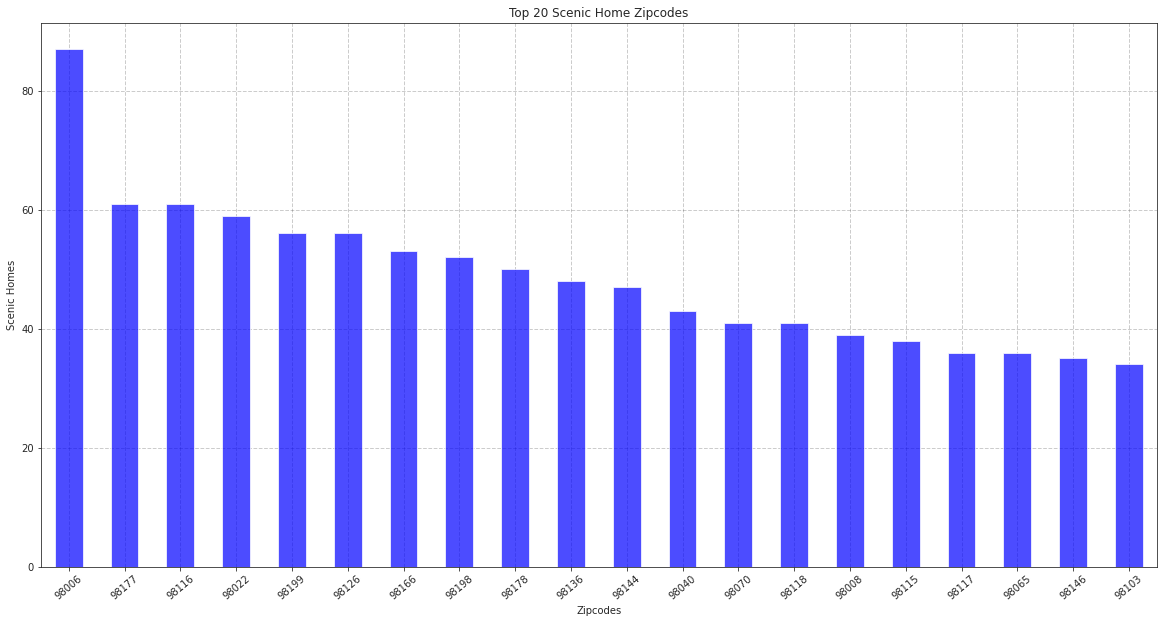

In [40]:
# Let's just focus on the top 20 zip codes
fig = plt.figure(figsize = (20, 10))
#plt.bar(scenic_by_zip.index, scenic_by_zip, color = 'red', alpha = 0.60)
top_20 = scenic_by_zip.nlargest(20)
top_20.plot.bar(rot=40, alpha = 0.70, color='blue', title='Top 20 Scenic Home Zipcodes')
plt.grid(color = 'black', alpha = 0.2, linestyle = '--', linewidth = 1)
#plt.title('Zipcodes with Scenic Homes)
plt.xlabel('Zipcodes')
plt.ylabel('Scenic Homes')

Text(0.5, 1.0, 'Scenic Homes Zipcode Clusters by Lat/Long Coordinates')

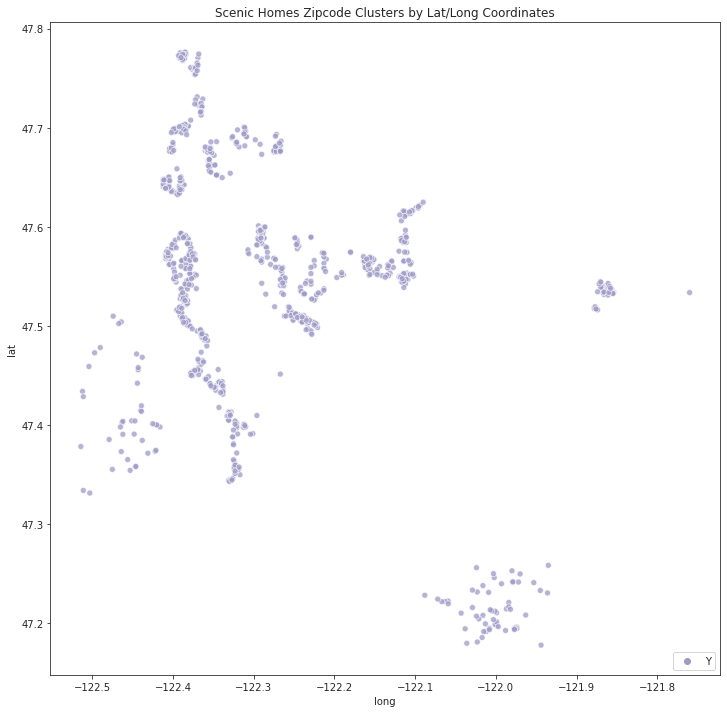

In [41]:
top_20_scenic_zips_ls = list(top_20.index.values)
top_20_scenic_zips_ls
top_20_scenic_zips_df = scenic_df[scenic_df['zipcode'].isin(top_20_scenic_zips_ls)]

plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='long', y='lat', hue=top_20_scenic_zips_df.scenic_status.tolist(), palette='Purples', data=top_20_scenic_zips_df, alpha=0.75)
# add a title manually
ax.legend(title='scenic_status')
plt.legend(loc='lower right')
plt.title('Scenic Homes Zipcode Clusters by Lat/Long Coordinates')

Text(0.5, 1.0, 'Scenic Homes Zipcode Clusters with Home Condition by Lat/Long Coordinates')

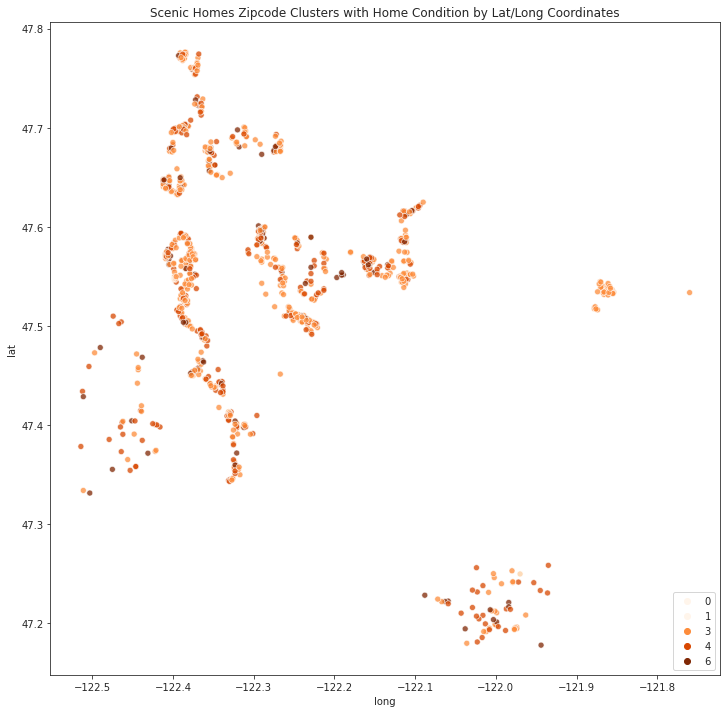

In [42]:
# Let's further our visualzation to show the condition rating of these scenic homes.
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='long', y='lat', hue=top_20_scenic_zips_df.condition.tolist(), palette='Oranges', data=top_20_scenic_zips_df, alpha=0.75)
# add a title manually
ax.legend(title='scenic_status')
plt.legend(loc='lower right')
plt.title('Scenic Homes Zipcode Clusters with Home Condition by Lat/Long Coordinates')

####  Intuition (and if you have bought property, experience) informs us that scenic homes are more expensive than homes without scenic attributes (waterfront and/or better than average view rank). Let's do some data visualizate to literally see if that is true.  Comparing regular home price distribution to scenic home price distribution by zip code.

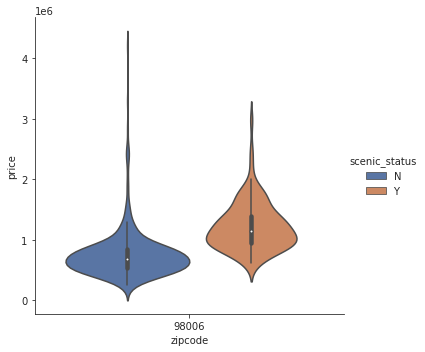

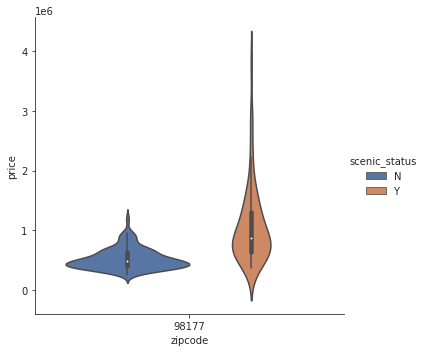

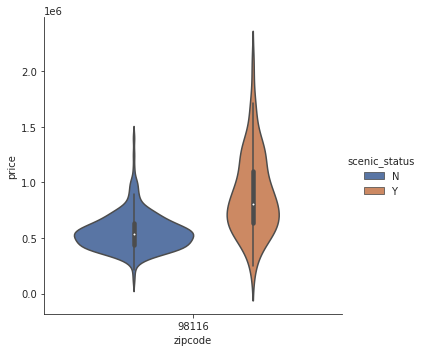

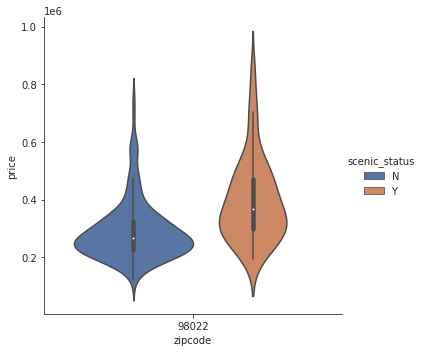

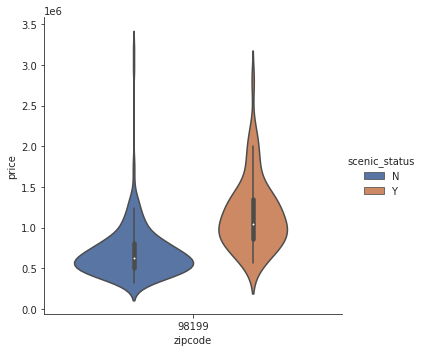

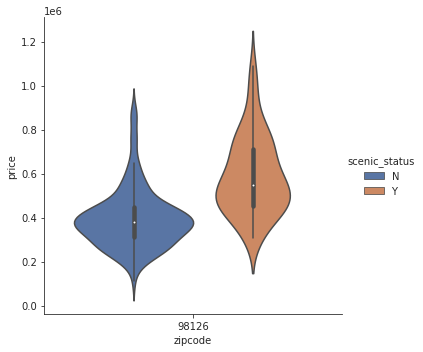

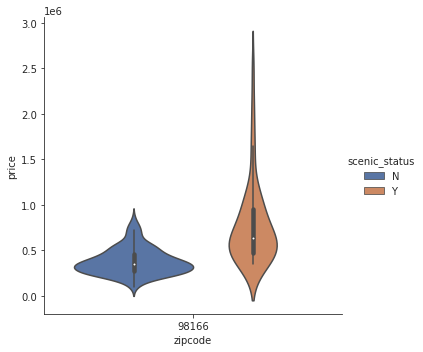

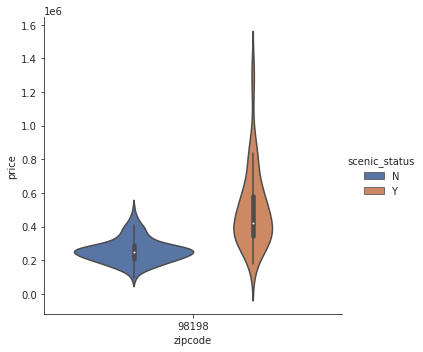

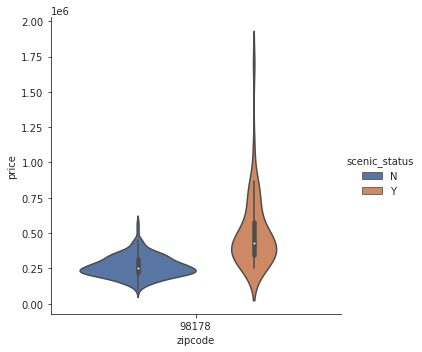

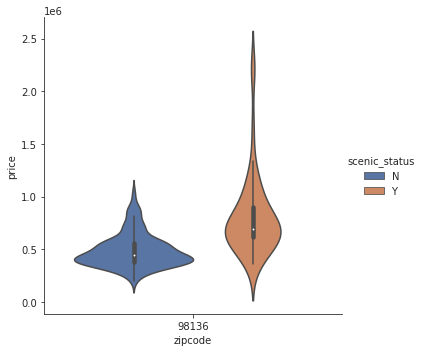

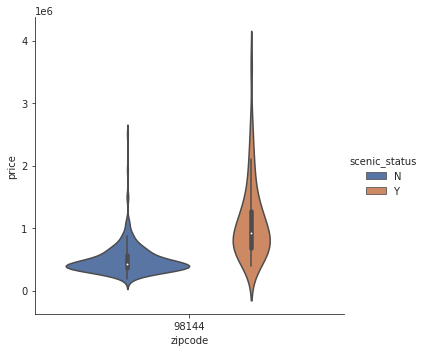

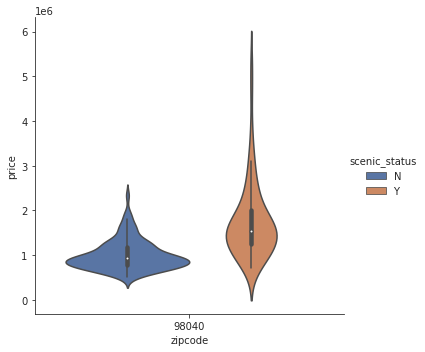

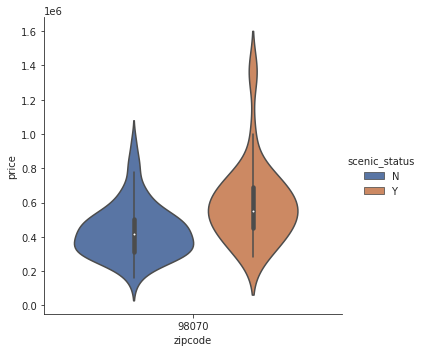

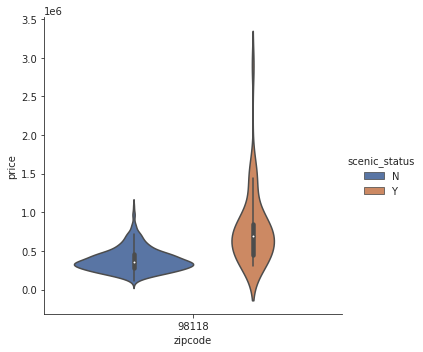

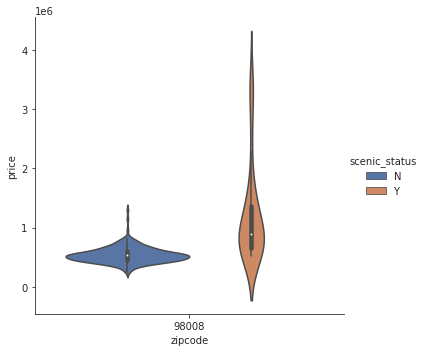

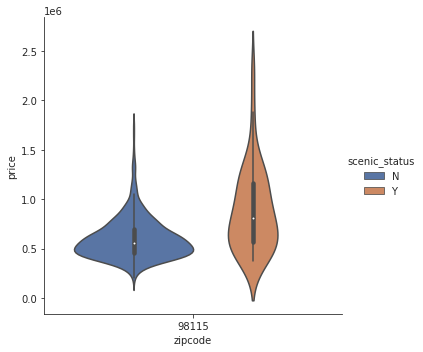

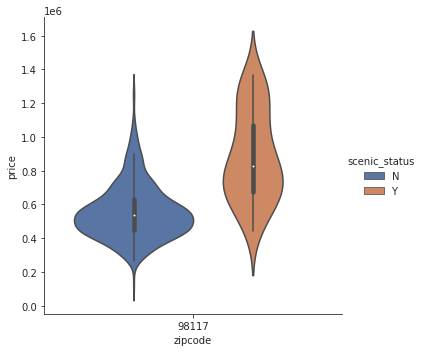

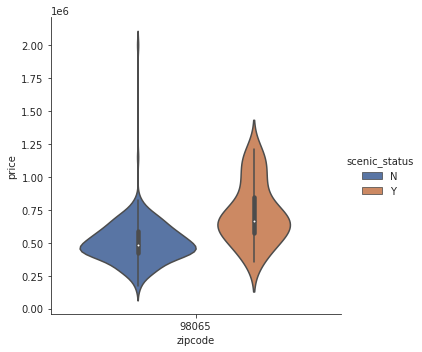

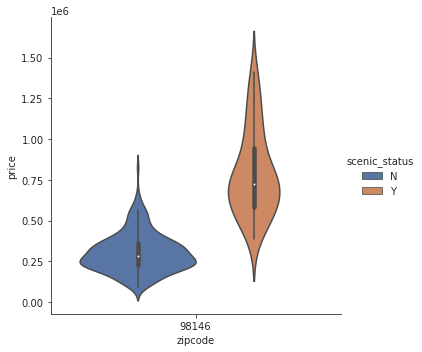

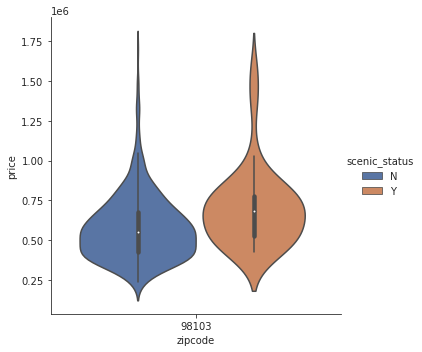

In [43]:
# In an attempt to have a more fair comparision between homes, compare homes in the same zip code.

for zip in scenic_by_zip.nlargest(20).index.values:
    scenic_zip_df = df[(df['zipcode'] == zip)]
    plot_grouped_violin('zipcode', 'price', 'scenic_status', ['N', 'Y'], scenic_zip_df, 'deep')
